## Training

1. Data upload
2. Training on subset for all possible configurations with random forest (interesting idea!)
3. Training on full data for best configuration with gradient boosting (catboost)

#### Data upload

Among features we have:
* Time series
* Simple features by Yahoo encoded with OHE (e.g. country and industry)
* Cluster features encoded with OHE (dtw and kmeans)
* Wavelet features
* Time series features provided by tsfel (e.g. mean, std, etc.)

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import os

root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data')

y_train_path = os.path.join(data_dir, 'y_train.csv')
y_test_path = os.path.join(data_dir, 'y_test.csv')

train_time_series_path = os.path.join(data_dir, 'X_train.csv')
train_simple_features_path = os.path.join(data_dir, 'X_simple_features_train.csv')
train_cluster_features_path = os.path.join(data_dir, 'cluster_features_train.csv')
train_wavelet_features_path = os.path.join(data_dir, 'X_train_wavelet.npy')
train_tsfel_features_path = os.path.join(data_dir, 'X_train_tsfel_features.npy')

test_time_series_path = os.path.join(data_dir, 'X_test.csv')
test_simple_features_path = os.path.join(data_dir, 'X_simple_features_test.csv')
test_cluster_features_path = os.path.join(data_dir, 'cluster_features_test.csv')
test_wavelet_features_path = os.path.join(data_dir, 'X_test_wavelet.npy')
test_tsfel_features_path = os.path.join(data_dir, 'X_test_tsfel_features.npy')

In [8]:
# all data should be loaded as numpy arrays

train = dict(
    ts = pd.read_csv(train_time_series_path).values, # time series data
    s_fs = pd.read_csv(train_simple_features_path).values, # simple features
    c_fs = pd.read_csv(train_cluster_features_path).values, # cluster features
    w_fs = np.load(train_wavelet_features_path), # wavelet features
    t_fs = np.load(train_tsfel_features_path) # tsfel features
)

test = dict(
    ts = pd.read_csv(test_time_series_path).values, # time series data
    s_fs = pd.read_csv(test_simple_features_path).values, # simple features
    c_fs = pd.read_csv(test_cluster_features_path).values, # cluster features
    w_fs = np.load(test_wavelet_features_path), # wavelet features
    t_fs = np.load(test_tsfel_features_path) # tsfel features
)

y_train = pd.read_csv(y_train_path).values.ravel()
y_test = pd.read_csv(y_test_path).values.ravel()

#### Training on subset

In [9]:
n_subset_train = 10000
n_subset_test = 1000

# note: I don't need to copy the data, since I'm not modifying it
train_ids = np.random.choice(range(train['ts'].shape[0]), n_subset_train, replace=False)
val_ids = np.random.choice(range(train['ts'].shape[0]), n_subset_test * 2, replace=False)
val_ids = np.setdiff1d(val_ids, train_ids)[:n_subset_test]
assert len(val_ids) == n_subset_test

train_sample = {k: v[train_ids] for k, v in train.items()}
y_train_sample = y_train[train_ids]

val_sample = {k: v[val_ids] for k, v in train.items()}
y_test_sample = y_train[val_ids]

In [10]:
def get_train_test(fs_types):
    """Return the training and testing data for the given feature types from sample data"""
    train_fs = np.hstack([train_sample[fs_type] for fs_type in fs_types])
    test_fs = np.hstack([val_sample[fs_type] for fs_type in fs_types])
    return train_fs, test_fs

FS_TYPES = ['ts', 's_fs', 'c_fs', 'w_fs', 't_fs']
def iterate_fs_types(fs_types=FS_TYPES, level=0):
    """Yield types for all posible feature types subsets"""
    if level == len(fs_types):
        if level == 0:
            return
        yield fs_types, *get_train_test(fs_types)
        return
    yield from iterate_fs_types(fs_types, level + 1)

    fs_types = fs_types[:level] + fs_types[level + 1:]

    yield from iterate_fs_types(fs_types, level)

cnt = 0
for fs_types, _, _ in iterate_fs_types():
    cnt += 1

assert cnt == 2**len(FS_TYPES) - 1, cnt

Time for random forest

In [11]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from pprint import pprint

# each result contains accuracy, f1-score, precision, recall
results = []
average_type = 'weighted'

progress_bar = tqdm(total=2**len(FS_TYPES) - 1, desc='Feature types combinations')
for fs_types, train_fs, test_fs in iterate_fs_types():
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(train_fs, y_train_sample)
    y_pred = clf.predict(test_fs)

    acc = accuracy_score(y_test_sample, y_pred)
    f1 = f1_score(y_test_sample, y_pred, average=average_type)
    prec = precision_score(y_test_sample, y_pred, average=average_type)
    rec = recall_score(y_test_sample, y_pred, average=average_type)

    results.append(dict(
        config=fs_types,
        accuracy=acc,
        f1=f1,
        precision=prec,
        recall=rec
    ))
    progress_bar.update(1)

Feature types combinations:  87%|████████▋ | 27/31 [08:50<00:43, 10.80s/it]c:\Users\rodio\Desktop\Programming\ML\market_forecasting\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Feature types combinations: 100%|██████████| 31/31 [09:34<00:00, 11.21s/it]

In [12]:
results_df = pd.DataFrame(results)
# sort by f1-score
sort_by = 'f1'
results_df = results_df.sort_values(sort_by, ascending=False)
results_df

,config,accuracy,f1,precision,recall
26,"[c_fs, t_fs]",0.576,0.564309,0.575509,0.576
18,"[s_fs, c_fs, t_fs]",0.572,0.562966,0.570448,0.572
22,"[s_fs, t_fs]",0.570,0.561148,0.568394,0.570
30,[t_fs],0.571,0.560311,0.572105,0.571
14,"[ts, t_fs]",0.566,0.544759,0.567159,0.566
23,[s_fs],0.538,0.536833,0.536811,0.538
2,"[ts, s_fs, c_fs, t_fs]",0.552,0.529691,0.549919,0.552
6,"[ts, s_fs, t_fs]",0.551,0.526838,0.553101,0.551
19,"[s_fs, c_fs]",0.529,0.526551,0.526849,0.529
10,"[ts, c_fs, t_fs]",0.550,0.526103,0.551358,0.550


In [13]:
best_config = results_df.iloc[0]['config']
train_fs = np.hstack([train[fs_type] for fs_type in best_config])
test_fs = np.hstack([test[fs_type] for fs_type in best_config])

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_fs, y_train)

RandomForestClassifier(random_state=42)

In [14]:
print("test report")
y_pred_test = clf.predict(test_fs)
print(classification_report(y_test, y_pred_test))

print("train report")
y_pred_train = clf.predict(train_fs)
print(classification_report(y_train, y_pred_train))

test report
              precision    recall  f1-score   support

          -1       0.34      0.14      0.20      4892
           0       0.51      0.76      0.61      8497
           1       0.40      0.30      0.34      5723

    accuracy                           0.46     19112
   macro avg       0.41      0.40      0.39     19112
weighted avg       0.43      0.46      0.43     19112

train report
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     27908
           0       1.00      1.00      1.00     47883
           1       1.00      1.00      1.00     32507

    accuracy                           1.00    108298
   macro avg       1.00      1.00      1.00    108298
weighted avg       1.00      1.00      1.00    108298



<Axes: >

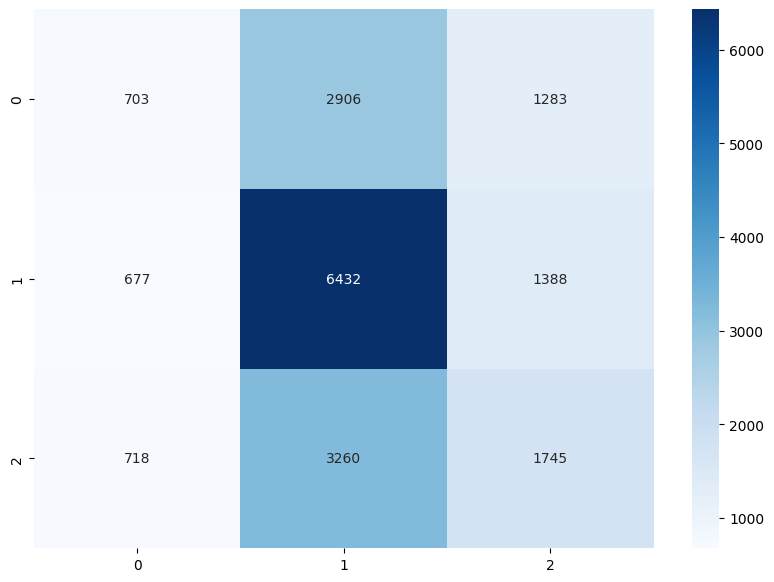

In [15]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

#### CatBoost Time!

In [16]:
from catboost import CatBoostClassifier


In [17]:
best_config = results_df.iloc[0]['config']

clf = CatBoostClassifier(iterations=10000)

train_fs = np.hstack([train[fs_type] for fs_type in best_config])
test_fs = np.hstack([test[fs_type] for fs_type in best_config])

clf.fit(train_fs, y_train, silent=True)

In [18]:
y_pred_test = clf.predict(test_fs)
y_pred_train = clf.predict(train_fs)

print("test report")
print(classification_report(y_test, y_pred_test))

print("train report")
print(classification_report(y_train, y_pred_train))

test report
              precision    recall  f1-score   support

          -1       0.32      0.16      0.22      4892
           0       0.52      0.72      0.60      8497
           1       0.37      0.31      0.34      5723

    accuracy                           0.45     19112
   macro avg       0.40      0.40      0.38     19112
weighted avg       0.42      0.45      0.42     19112

train report
              precision    recall  f1-score   support

          -1       0.81      0.61      0.69     27908
           0       0.69      0.84      0.76     47883
           1       0.77      0.69      0.72     32507

    accuracy                           0.73    108298
   macro avg       0.76      0.71      0.73    108298
weighted avg       0.74      0.73      0.73    108298



<Axes: >

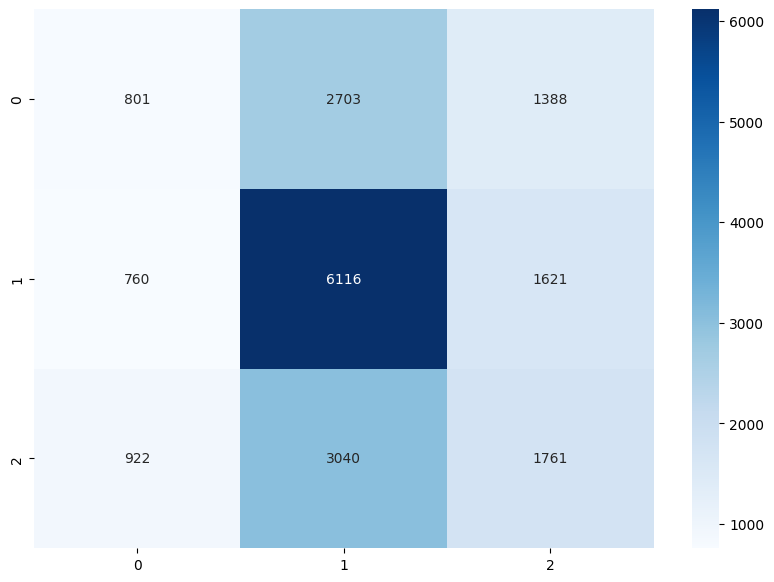

In [19]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

Okay, it looks like in the most cases the model chooses just majority class